# **Imports**

In [1]:
import os
import random
import time
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from skimage import exposure
import torchvision.transforms as T

import scipy.ndimage as ndi
import skimage.morphology as morph
from skimage.filters import threshold_otsu

In [2]:
TEST = False

data_directory = '../input/sartorius-cell-instance-segmentation'
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 2
NUM_EPOCHS = 20

TRAIN_CSV = f"{data_directory}/train.csv"
TRAIN_PATH = f"{data_directory}/train"
TEST_PATH = f"{data_directory}/test"

WIDTH = 704
HEIGHT = 520

# **Utils**

In [3]:
# ref: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    if len(shape)==3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)


def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 12))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# **Mask Utils**

In [4]:
def clean_mask(mask):
    mask = mask > threshold_otsu(np.array(mask).astype(np.uint8))
    mask = ndi.binary_fill_holes(mask)
    
    return mask

# **Dataset + Hole Filling**

In [5]:
cell_type_dict = {"astro": 1, "cort": 2, "shsy5y": 3}

class CellDataset(Dataset):
    def __init__(self, image_dir, df, show_filled):
        self.image_dir = image_dir
        self.df = df
        self.height = HEIGHT
        self.width = WIDTH
        self.show_filled = show_filled
        
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby(["id", "cell_type"])['annotation'].agg(lambda x: list(x)).reset_index()
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                    'image_id': row['id'],
                    'image_path': os.path.join(self.image_dir, row['id'] + '.png'),
                    'annotations': list(row["annotation"]),
                    'cell_type': cell_type_dict[row["cell_type"]]
                    }
            
    def get_box(self, a_mask):
        ''' Get the bounding box of a given mask '''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        ''' Get the image and the target'''
        
        img_path = self.image_info[idx]["image_path"]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        
        info = self.image_info[idx]

        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []
        labels = []
        for i, annotation in enumerate(info['annotations']):
            a_mask = rle_decode(annotation, (HEIGHT, WIDTH))
            
            a_mask = np.array(a_mask) > 0
            if self.show_filled:
                a_mask = clean_mask(a_mask)   # CALL THE REFINEMENT FUNCTION
            masks[i, :, :] = a_mask
            
            boxes.append(self.get_box(a_mask))

        labels = [int(info["cell_type"]) for _ in range(n_objects)]
        
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        return img, target

    def __len__(self):
        return len(self.image_info)

In [6]:
ds_train = CellDataset(TRAIN_PATH, pd.read_csv(TRAIN_CSV), show_filled=False)

# **Problem: Masks are not fully filled**

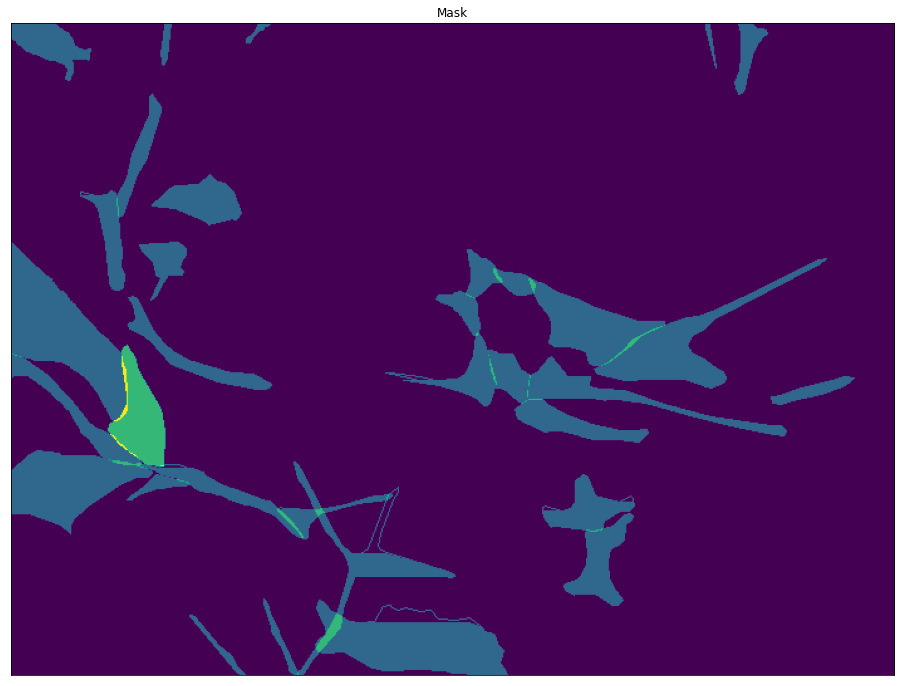

In [7]:
image, masks = ds_train[20]
masks = np.array(masks["masks"])
mask = masks[0, :, :]
for i in range(len(masks)):
    mask += masks[i, :, :]
image = image[0, :, :]

visualize(
    mask=mask,
)

# **Results**

In [8]:
ds_train = CellDataset(TRAIN_PATH, pd.read_csv(TRAIN_CSV), show_filled=True)

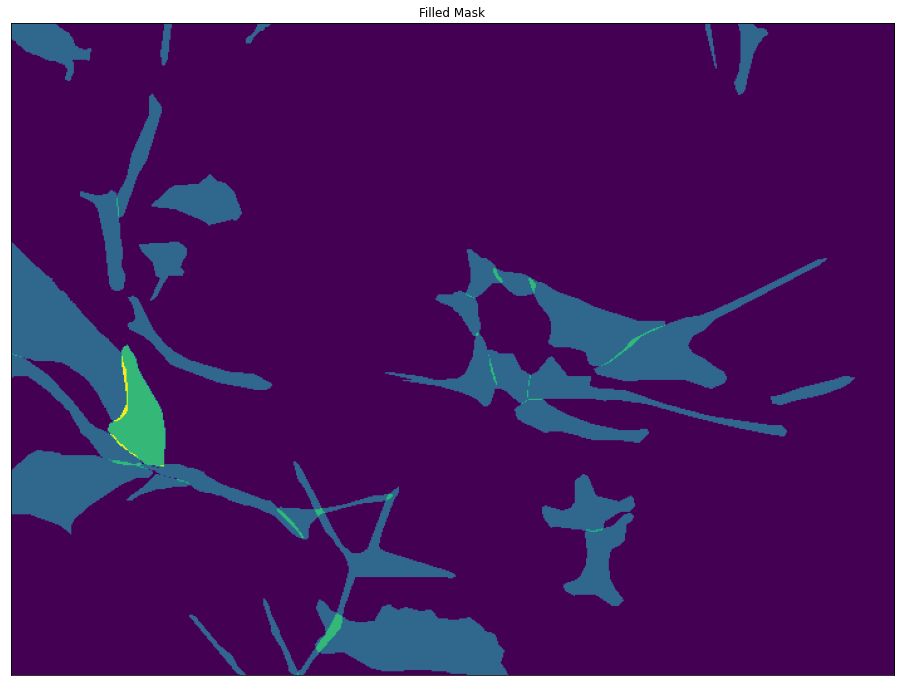

In [9]:
image, masks = ds_train[20]
masks = np.array(masks["masks"])
mask = masks[0, :, :]
for i in range(len(masks)):
    mask += masks[i, :, :]
image = image[0, :, :]

visualize(
    filled_mask=mask
)